# Dataset preparation for Unet Evaluation

In this file a dataset is created to train a 3D Unet with. This task encompasses the following steps:

- Open Tiff Stacks / h5 or n5 files
- data exploration and visualization
- sample mining
- creation of training datasets

In [1]:
import numpy as np 
import os, sys
import matplotlib.pyplot as plt
from importlib import reload
from scipy.stats import linregress

import h5py, z5py

sys.path.append('../../tools/')
import tilingStrategy, Dataset3D, visualization

In [2]:
reload(visualization)
reload(Dataset3D)
reload(tilingStrategy)

<module 'tilingStrategy' from '../../tools\\tilingStrategy.py'>

## Data Import
Open the different image regions and load the channels containing the image and a crude (overmasked) VVD mask of the neuron

In [3]:
region_directory = "D:\\Janelia\\UnetTraining\\RegionCrops\\" # location of the folder holding the regions
region_paths = ["R1\\R1.h5","R2\\R2.h5","Q1\\Q1.h5","Q2\\Q2.h5"]
regions = ["R1","R2","Q1","Q2"]

image_paths = [region_directory + region for region in region_paths] # prepend base dir to all regions in the list
regions_h5 = [h5py.File(ip, mode='r+') for ip in image_paths] # open the image regions

for h5 in regions_h5:
    print(h5.filename)
    print(h5['t0'].keys())
    print('')

D:\Janelia\UnetTraining\RegionCrops\R1\R1.h5
<KeysViewHDF5 ['channel0', 'channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7']>

D:\Janelia\UnetTraining\RegionCrops\R2\R2.h5
<KeysViewHDF5 ['channel0', 'channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7']>

D:\Janelia\UnetTraining\RegionCrops\Q1\Q1.h5
<KeysViewHDF5 ['channel0', 'channel1', 'channel2']>

D:\Janelia\UnetTraining\RegionCrops\Q2\Q2.h5
<KeysViewHDF5 ['channel0', 'channel1', 'channel2']>



In [4]:
#Build a dictionary for the image and mask arrays of each region
image = {}
mask = {}
# Mapping of regions and channel information can be found in the exel file located in the folder where the regions are stored
image['R1'] = regions_h5[0]['t0/channel4']
mask['R1'] = regions_h5[0]['t0/channel5']
image['R2'] = regions_h5[1]['t0/channel4']
mask['R2'] = regions_h5[1]['t0/channel5']
image['Q1'] = regions_h5[2]['t0/channel1']
mask['Q1'] = regions_h5[2]['t0/channel2']
image['Q2'] = regions_h5[3]['t0/channel1']
mask['Q2'] = regions_h5[3]['t0/channel2']


## Z-Score Normalization
Since data is incorporated from different specimens, we have to calculate the empirical mean and std for each region. (They should be comparable between regions of the same specimen)
The data has to be preprocessed ONCE -> keep code for reference but comment it out once we have done our processing

In [5]:
region_mean = []
region_std = []
region_hist = []
for region in regions:
    im = image[region]#[...] # load numpy array into working memory
    region_mean.append(np.mean(im))
    region_std.append(np.std(im))
    region_hist.append(np.histogram(im,bins=100,range=[0,2000]))

mean + 40*sigma = 1223.4583751308996
mean + 40*sigma = 2077.975693889488
mean + 40*sigma = 1680.3888647316703
mean + 40*sigma = 626.4505504567366


[None, None, None, None]

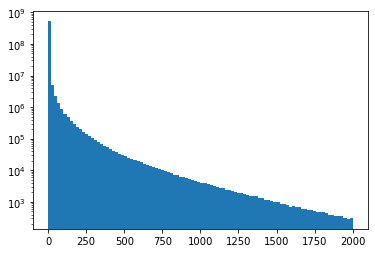

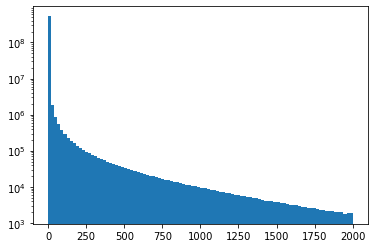

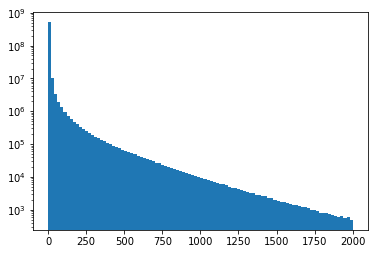

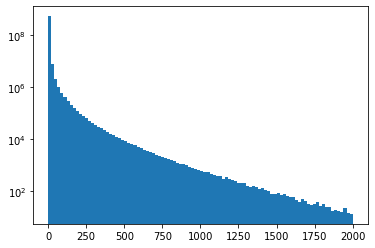

In [6]:
for count, bins in region_hist:
    plt.figure()
    plt.hist(bins[:-1], bins, weights=count, log=True)

[print('mean + 40*sigma = ' + str(m+40*s)) for m,s in zip(region_mean,region_std)]


In [7]:
def preprocessImage(x, mean, std):
    # clip, and z normalize image
    x = np.clip(x,0, 1400)
    x = np.subtract(x, mean)
    x = np.divide(x, std)
    x = x.astype(np.float32)
    return x

def preprocessMask(x):
    # binarize mask and one hot encode
    x = np.clip(x,0,1)
    x = x.astype(np.int32)
    return x


In [8]:
# TODO apply z score normalization to data -> work with numpy arrays copied into working memory
for region, mean, std in zip(regions, region_mean, region_std):
    image[region] = preprocessImage( image[region][...], mean, std ) # load from hdf5 into working memory
    mask[region]  = preprocessMask( mask[region][...] )
    


In [9]:
# Validate Z Normalization
region_mean_n = []
region_std_n = []
region_hist_n = []
for region in regions:
    im = image[region]#[...] # load numpy array into working memory
    region_mean_n.append(np.mean(im))
    region_std_n.append(np.std(im))
    region_hist_n.append(np.histogram(im,bins=100,range=[-5,20]))

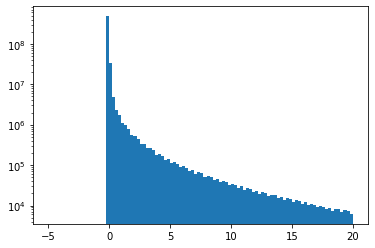

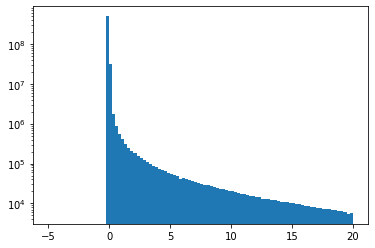

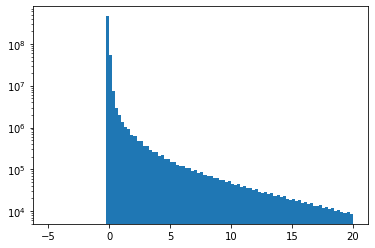

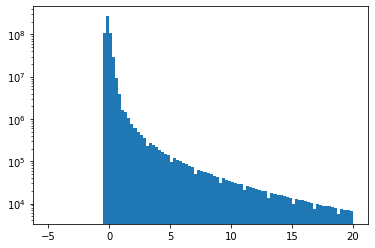

In [10]:
for count, bins in region_hist_n:
    plt.figure()
    plt.hist(bins[:-1], bins, weights=count, log=True)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 128.29it/s]


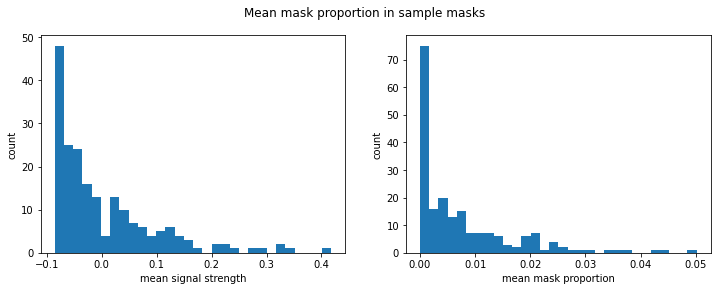

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 129.41it/s]


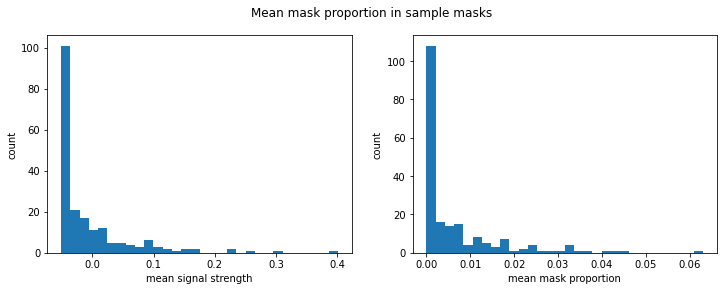

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 130.56it/s]


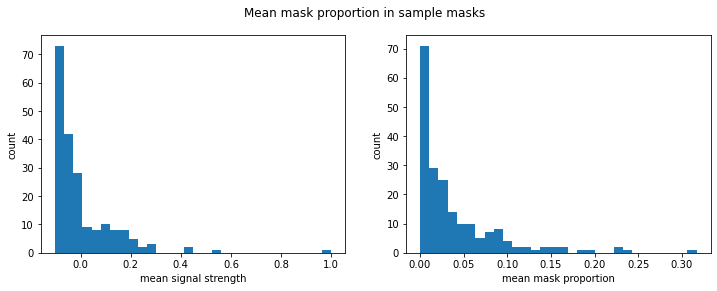

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 131.55it/s]


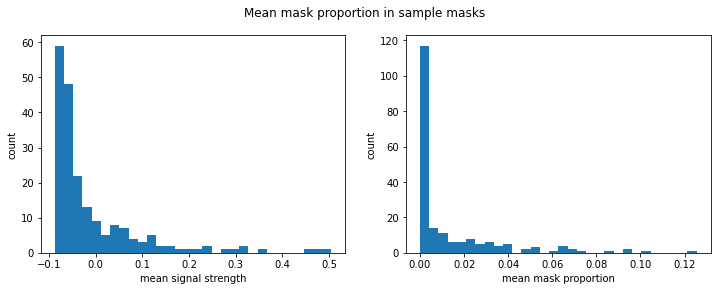

In [11]:
tiler = {}
indices = {}
mask_proportions = {}
signal_strengths = {}
mask_thresholded = {}

for region in regions:
    # Use UnetTiler to tile the image volume with a rectangular grid
    tiler[region] = tilingStrategy.UnetTiler3D(image=image[region], mask=mask[region], output_shape=(132,132,132), input_shape=(220,220,220))
    # since input = ouput shape there is no padding
    indices = Dataset3D.getRandomIndices(tiler[region], n_samples=200) # sample random tiles from the image volume

    # Plot the distribution of the mean signal strength in our samples
    signal_strengths[region] = Dataset3D.getMeanSignalStrengths(tiler[region], indices) # With about 17% of samples containing the neuron this should be enough sampling to collect 50 samples for the dataset
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    _ = plt.hist(signal_strengths[region], bins=30)
    plt.suptitle('Mean signal strength in region ' + region)
    plt.xlabel('mean signal strength')
    plt.ylabel('count')

    # Plot the distribution of mask proportion
    mask_proportions[region] = Dataset3D.sampleMaskProportion(tiler[region], indices)
    plt.subplot(1,2,2)
    plt.suptitle('Mean mask proportion in sample masks')
    _ = plt.hist(mask_proportions[region], bins=30)
    plt.xlabel('mean mask proportion')
    plt.ylabel('count')
    plt.show()

    # Prepare a detaset with mask thresholded sampling
    mask_thresholded[region] = Dataset3D.thresholdedSampling(indices, mask_proportions[region], threshold=0.001, above_threshold_ratio=0.9, n_samples=50)

### Exploring the relation between Signal strength and mask Proportion in the tiles

Divide the tiles into groups with a specific proportion of the mask between 0 and the maximum proportion. Create a database by sampling each class with equal probability

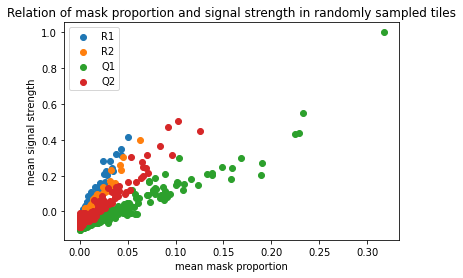

In [12]:
# visualize ethe relation between mean signal strength and mask proportion
plt.figure()
for region in regions:
    plt.scatter(mask_proportions[region],signal_strengths[region])
    plt.ylabel('mean signal strength')
    plt.xlabel('mean mask proportion')
plt.title('Relation of mask proportion and signal strength in randomly sampled tiles')
plt.legend(regions)


slope: 9.759121    intercept: -0.070562
R-squared: 0.948414


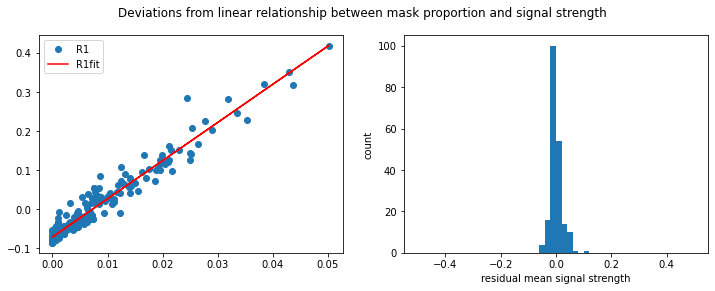

slope: 6.638392    intercept: -0.047794
R-squared: 0.968592


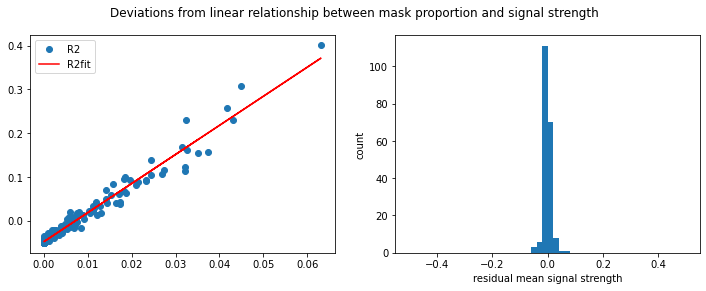

slope: 2.486106    intercept: -0.096121
R-squared: 0.919113


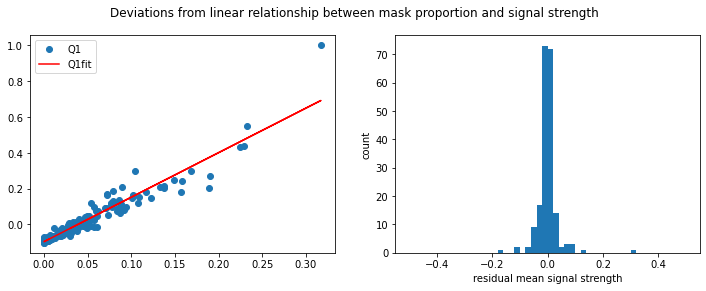

slope: 4.622619    intercept: -0.067837
R-squared: 0.938511


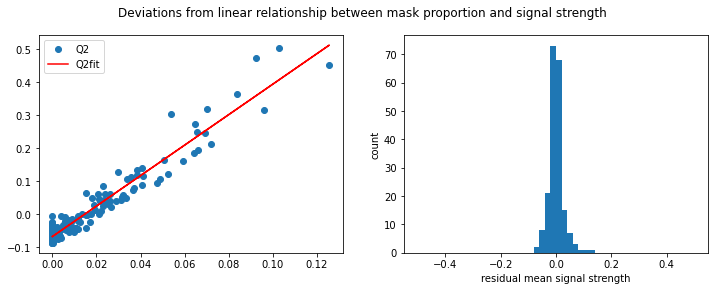

In [13]:
residuals = {}

for region in regions:
    # use mask proportion as input to predict signal strength. If points are significantly above predicted line, they contain bright blobs
    slope, intercept, r_value, p_value, std_err = linregress(x=mask_proportions[region],y=signal_strengths[region])
    print("slope: %f    intercept: %f" % (slope, intercept))
    print("R-squared: %f" % r_value**2)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(mask_proportions[region], signal_strengths[region], 'o', label=region,)
    plt.plot(mask_proportions[region], intercept + np.multiply(slope,mask_proportions[region]), 'r', label=region+'fit')
    plt.legend()

    plt.subplot(1,2,2)
    residuals[region] = signal_strengths[region] - (intercept + np.multiply(slope, mask_proportions[region]))
    _ = plt.hist(residuals[region], bins=50, range=[-.5,.5])
    plt.suptitle('Deviations from linear relationship between mask proportion and signal strength')
    plt.xlabel('residual mean signal strength')
    plt.ylabel('count')
    plt.show()

## Create a dataset

Use the Dataset3D class to create a new dataset or append to an existing one.
Datasets contain named entries that hold an input image and it's corresponding mask together with some metadata.

In [14]:
reload(Dataset3D)
dataset = Dataset3D.Dataset(dataset_path='D:\\Janelia\\UnetTraining\\Evaluation\\20200928_eval.h5')
dataset.keys()

../../tools\Dataset3D.py:134: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.dataset_h5 = h5py.File(dataset_path)


<KeysViewHDF5 []>

In [15]:
for i, region in enumerate(regions):
    dataset.add_tiles(tiler[region], mask_thresholded[region],
        key_prefix=region,
        cropMask=False,
        metadata={'region': region,'source_image':image_paths[i], 'preprocessing':'Clip at 1400, z score normalization with empirical region mean and std', 'date':'20200921'})

Tiles added: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.15s/it]


In [16]:
# Close the dataset
print(dataset.keys())
dataset.close()

<KeysViewHDF5 ['Q110', 'Q1103', 'Q1106', 'Q111', 'Q1115', 'Q1120', 'Q1122', 'Q1123', 'Q1128', 'Q1135', 'Q1136', 'Q1142', 'Q1148', 'Q1149', 'Q1152', 'Q1153', 'Q1158', 'Q1167', 'Q1168', 'Q117', 'Q1176', 'Q1179', 'Q1180', 'Q1183', 'Q119', 'Q1198', 'Q12', 'Q1205', 'Q1207', 'Q1209', 'Q1211', 'Q1216', 'Q1221', 'Q1224', 'Q1230', 'Q1231', 'Q1232', 'Q1234', 'Q1251', 'Q146', 'Q151', 'Q154', 'Q158', 'Q164', 'Q169', 'Q173', 'Q177', 'Q182', 'Q196', 'Q197', 'Q20', 'Q2103', 'Q2105', 'Q2107', 'Q211', 'Q2115', 'Q2116', 'Q2130', 'Q2133', 'Q2138', 'Q2141', 'Q2145', 'Q2147', 'Q2154', 'Q2155', 'Q2158', 'Q2162', 'Q2164', 'Q2165', 'Q2167', 'Q2171', 'Q2172', 'Q2186', 'Q2196', 'Q2197', 'Q2200', 'Q2204', 'Q2206', 'Q2207', 'Q2209', 'Q2212', 'Q2215', 'Q2216', 'Q2230', 'Q2235', 'Q2239', 'Q2244', 'Q2246', 'Q2247', 'Q239', 'Q240', 'Q246', 'Q252', 'Q257', 'Q268', 'Q277', 'Q285', 'Q292', 'Q296', 'Q297', 'R110', 'R1100', 'R1105', 'R1107', 'R1109', 'R111', 'R1112', 'R1114', 'R1118', 'R1119', 'R1120', 'R1122', 'R1124', '

## Inspect a prepared dataset

In [21]:
# Open the dataset
reload(Dataset3D)
dataset = Dataset3D.Dataset(dataset_path='D:\\Janelia\\UnetTraining\\Evaluation\\20200928_eval.h5')

Opened dataset with 199 preexisting items. Overwriting items with the same name.


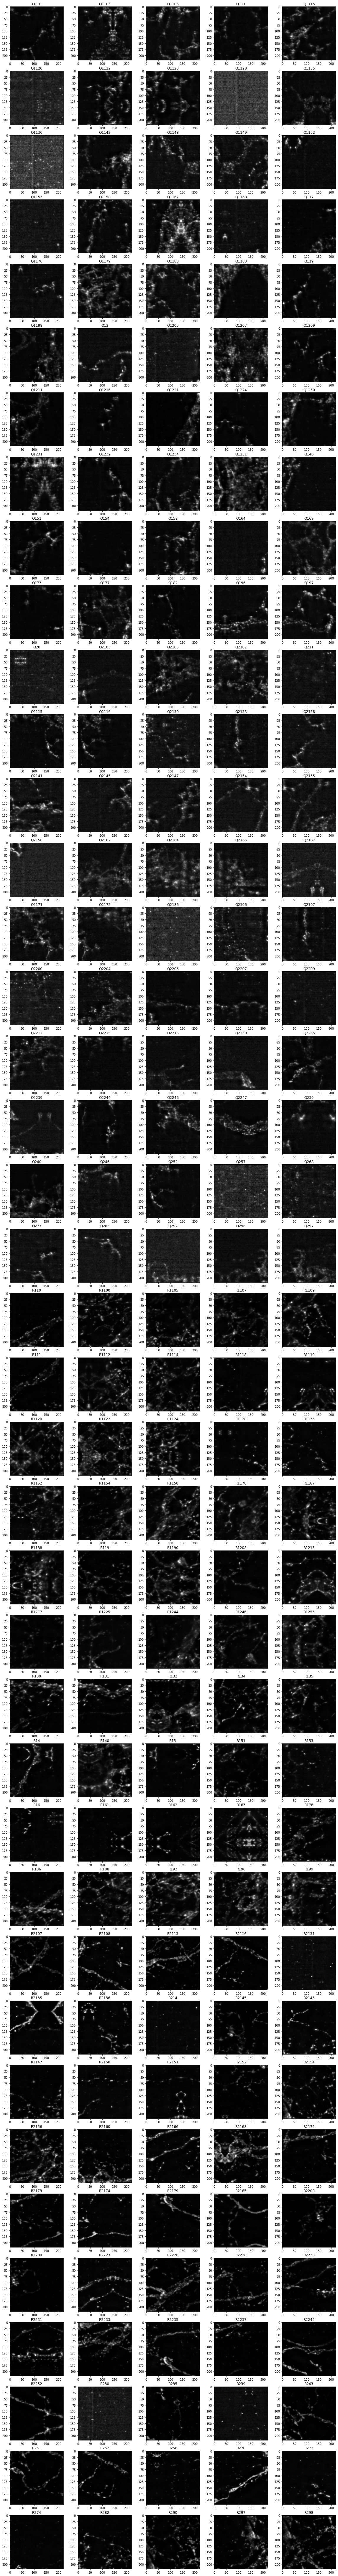

In [18]:
# Visualize the content of a generated dataset
plt.figure(figsize=(20,160))
samples = list(dataset.keys())
for i, sample in enumerate(samples):
    plt.subplot(40,5,i+1)
    plt.gca().set_title(sample)
    plt.imshow(np.sum(dataset.get(sample)[0], axis=0), cmap='gray')

In [19]:
bad_entries = ['Q1128']
[dataset.delete(entry) for entry in bad_entries]

[None]

In [20]:
dataset.close()